In [ ]:
import os
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization,LeakyReLU
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle
import tensorflow as tf
#from VizCallbackTrial import VizCallback

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
batchSize = 64
valBatchSize = 20
width = 128
height = 32
valSplit = 0.02
trainSamplesPerEpoch = 25000
valSamplesPerEpoch = 1000
noEpochs = 50
wordFile = 'Newtrainnval.txt'
unicodes = list(np.load('unicodes.npy',allow_pickle=True))


def binarise(im):
    for i in range(im.shape[2]):
        k = im[:,:,i]
        p = np.max(k)
        q = np.min(k)
        k[k==p] = 1
        k[k==q] = 0
        im[:,:,i] = k
    return im
"""
with open('NewtrainnvalTranspose.pickle','rb') as f:
  im = pickle.load(f) 
"""

#im = binarise(imw)
dict_trainnval = {}
infile = open('/content/drive/My Drive/Colab Notebooks/CRNN/Newtrainnval.txt','r')
integer = 0
for line in infile:
  integer += 1
  lineSplit = line.strip().split(' ')
  dict_trainnval[lineSplit[0]] = integer


class VizCallback(keras.callbacks.Callback):

    def __init__(self, test_func, nextVal, num_display_words=1):
        self.test_func = test_func
        self.text_img_gen = nextVal
        self.num_display_words = num_display_words
        
    def on_epoch_end(self, epoch, logs={}):
        wordBatch = next(self.text_img_gen)[0]
        imgs = wordBatch['inputX']
        trueText = np.uint8(wordBatch['label'])
        out = self.test_func([imgs])[0]
        predText = decode(out)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):    
            true = labelsToText(list(trueText[i]))
            wordOK += 1 if predText[i]==true else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],true)
            charDist += dist
            charTot += len(true)
            print(true,predText[i])
        charDist = charDist/charTot
        wordOK = wordOK/wordTot
        print('Character Distance(CER):'+str(charDist*100))
        print('Word Accuracy:'+str(wordOK*100))


def plotHistory(history, key = 'loss'):
    plt.figure()
    plt.plot(history.epoch, history.history['val_'+key],'--', label=' Val')
    plt.plot(history.epoch, history.history[key],label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])

def crop(image):
    H,W = image.shape
    _,img = cv2.threshold(image,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY)#cv2.THRESH_OTSU+
    vertical = np.sum(img,axis=1)
    p, q, r, s = 0, H, 0, W
    if np.amin(vertical) == 0 and np.argmin(vertical) < int(H/2):
        for m in range(np.argmin(vertical),len(vertical)):
            if vertical[m] != 0:
                break
        p = m+np.argmin(vertical)+1
    if np.amin(vertical[p:]) == 0 and np.argmin(vertical[p:]) > int(H/2):
        q = np.argmin(vertical[p:])-1
    horizontal = np.sum(img,axis=0)
    if np.amin(horizontal) == 0 and np.argmin(horizontal) < int(W/2):
        for n in range(np.argmin(horizontal),len(horizontal)):
            if horizontal[n] != 0:
                break
        r = n+np.argmin(horizontal)+1
    if np.amin(horizontal[r:]) == 0 and np.argmin(horizontal[r:]) > int(W/2):
        s = np.argmin(horizontal[r:])-1
    im = img[p:q,r:s]    
    kernel = np.ones((4,4),dtype='uint8')
    Img = cv2.dilate(im,kernel,iterations=1)
    h, w = Img.shape
    for i in range(w):
        array = Img[:,i]
        l = array.shape[0]
        if np.amin(array) == 0 and np.argmin(array) < 3*int(l/100) and i >= int(w/100):
            for ii in range(np.argmin(array)+1,l):
                if array[ii] != array[ii-1]:
                    #arr = array[ii:]
                    break
            if np.amin(array[ii:]) == 0 and np.argmin(array) < l - 3*int(l/100) and i >= int(w/100):
                a = max(i-1,0)
                break
        elif np.amin(array) == 0 and np.argmin(array) > 3*int(l/100) and np.argmin(array) < l-3*int(l/100) and i >= int(w/100):
            a = max(i-1,0)
            break  
    for j in range(w-1,-1,-1):
        jarray = Img[:,j]
        l = jarray.shape[0]
        if np.amin(jarray) == 0 and np.argmin(jarray) < 3*int(l/100) and j <= w-int(w/100):
            for jj in range(np.argmin(jarray)+1,l):
                if jarray[jj] != jarray[jj-1]:
                    #arr = array[jj:]
                    break
            if np.amin(jarray[jj:]) == 0 and np.argmin(jarray) < l - 3*int(l/100) and j <= w-int(w/100):
                b = j+2 if j>0 else w-1
                break
        elif np.amin(jarray) == 0 and np.argmin(jarray) > 3*int(l/100) and np.argmin(jarray) < l-3*int(l/100) and j <= w-int(w/100):
            b=j+2 if j>0 else w-1
            break           
    imag = Img[:,a:b]
    for k in range(h):
        vector = imag[k,:]
        if np.amin(vector) == 0 and k > 7*int(h/100):
            c = max(k-1,0)
            break    
    for kk in range(h-1,-1,-1):
        array = imag[kk,:]
        if np.amin(array) == 0 and kk < h-4*int(h/100):
            d = kk+1 if kk>0 else h-1
            break
            
    I = im[c:d,a:b]
    J = image[p+c:min(p+d,h),r+a:min(r+b,w)]

    return J

def preprocess(imag, imgSize, dataAugmentation=0):
    imag = cv2.medianBlur(imag,3)
    J = cv2.resize(imag,(128,32))
    rt3,_ = cv2.threshold(J,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N,_ = np.histogram(J,[i for i in range(0,256)])
    f = np.argmax(N[int(rt3):])
    rt4 = int(rt3+0.7*f)
    _,k = cv2.threshold(J,rt4,255,cv2.THRESH_BINARY) 
    if dataAugmentation==1:
    	stretch = (random.random() - 0.5) # -0.5 .. +0.5
    	wStretched = max(int(k.shape[1] * (1 + stretch)), 1) # random width, but at least 1
    	k = cv2.resize(k, (wStretched, k.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    (wt, ht) = imgSize
    h = imag.shape[0]
    w = imag.shape[1]
    fx = w / wt #4
    fy = h / ht #3
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(k, newSize)#, cv2.INTER_AREA
    n,_ = np.histogram(img,[i for i in range(257)])
    nn = n[1:255]
    for j in range(len(nn)):
        if (np.sum(nn[:j])-np.sum(nn[j:]))/100 >= 0.25*np.sum(nn):
            break
    rt5 = j+1
    _,ii = cv2.threshold(img,rt5,255,cv2.THRESH_BINARY)
    H,W = ii.shape
    l,b = 32 - H, 128 - W
    if l%2 == 1:
        top, bottom = int(l/2) + 1, int(l/2)
    else:
        top, bottom = int(l/2), int(l/2)
    
    if b%2 == 1:
        left, right = int(b/2) + 1, int(b/2)
    else:
        left, right = int(b/2), int(b/2)
    FinalImage = cv2.copyMakeBorder(ii, top, bottom, left, right, cv2.BORDER_CONSTANT,255,255)
    #rotatedImg = cv2.rotate(FinalImage, cv2.ROTATE_90_CLOCKWISE)
    rotatedImg = cv2.transpose(FinalImage)
    (m, s) = cv2.meanStdDev(rotatedImg)
    m = m[0][0]
    s = s[0][0]
    img = rotatedImg - m
    img = img / s if s>0 else img
    return np.reshape(img,(128,32,1))

def textToLabels(text):
    ret = []
    for c in text:
        ret.append(unicodes.index(c))
    return ret

def labelsToText(labels):
    ret = []
    for c in labels:
        if c == len(unicodes):
            ret.append("")
        else:
            ret.append(unicodes[c])
    return "".join(ret)
        

class DataGenerator(keras.callbacks.Callback):
    def __init__(self,batchSize,valBatchSize,width,height,valSplit,downsampleFactor = 4 , maxStringLen = 32):
        self.batchSize = batchSize
        self.imgW = width
        self.imgH = height
        self.downSampleFactor = downsampleFactor
        self.valSplit = valSplit
        self.blankLabel = len(unicodes)
        self.wordFile = wordFile
        self.maxStringLen = maxStringLen
        self.trainSet = None
        self.valSet = None
        self.dataset = []
        self.trainIndex = 0
        self.valBatchSize = valBatchSize
        self.valIndex = 0
        self.getData()
        
    def getData(self):
        f = open(self.wordFile,'r',encoding='utf-8')
        for line in f:
            if not line or line[0] =='#':
                continue
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 2
            fileName = lineSplit[0] # '/content/drive/My Drive/Colab Notebooks/CRNN/' +
            text = self.truncateLabel(' '.join(lineSplit[1:]))
            
            for ch in text:
                if ch not in unicodes:
                    print(ch,('0'+hex(ord(ch))[2:]))
                    
            #text = text.replace('\n','')              #Removing LF newlines
            self.dataset.append((text,fileName))
        self.splitData()
        f.close()
            
    def splitData(self):
        random.shuffle(self.dataset)
        self.valSet = self.dataset[:int(self.valSplit*len(self.dataset))]
        random.shuffle(self.valSet)
        self.trainSet = self.dataset[int(self.valSplit*len(self.dataset)):]
        random.shuffle(self.trainSet)
        self.trainIndex = 0
        self.valIndex = 0
    
    def truncateLabel(self,text):
        cost = 0
        for i in range(len(text)):
            if i!=0 and text[i]==text[i-1]:
                cost+=2
            else:
                cost+=1
            if cost>self.maxStringLen:
                return text[:i]
        return text
    
    def getBatch(self,index,size,train):
        if train:
            batch = self.trainSet[index:index+size]
        else:
            batch = self.valSet[index:index+size]
        imgs = []
        labels = np.ones([size, self.maxStringLen])*(len(unicodes))
        inputLength = np.zeros([size, 1])
        labelLength = np.zeros([size, 1])
        for i in range(size):
            #img = cv2.imread(batch[i][1],0)
            kk = dict_trainnval[batch[i][1]]
            imgs.append(np.reshape(im[:,:,kk-1],(128,32,1)))
            labels[i, 0:len(batch[i][0])] = textToLabels(batch[i][0])
            labelLength[i] = len(batch[i][0])
            inputLength[i] = self.imgW // self.downSampleFactor - 2
        imgs = np.asarray(imgs)
        inputs = {
                'inputX': imgs,
                'label': labels,
                'inputLen':inputLength,
                'labelLen':labelLength,
                    }
        outputs = {'ctc':np.zeros([size])}
        return (inputs,outputs)
            
    def nextTrain(self):
        while True:
            if self.trainIndex + self.batchSize >= len(self.trainSet):
                self.trainIndex = self.trainIndex % self.batchSize
                random.shuffle(self.trainSet)   
            ret = self.getBatch(self.trainIndex,self.batchSize,True)
            self.trainIndex += self.batchSize
            yield ret
            
    def nextVal(self):
        while True:
            if self.valIndex + self.valBatchSize >= len(self.valSet):
                self.valIndex = self.valIndex % self.valBatchSize
                random.shuffle(self.valSet)   
            ret = self.getBatch(self.valIndex,self.valBatchSize,False)
            self.valIndex += self.valBatchSize
            yield ret

def ctcLambdaFunc(args):
    yPred, labels, inputLength, labelLength = args
    yPred = yPred[:,2:,:]
    loss = K.ctc_batch_cost(labels,yPred,inputLength,labelLength)
    return loss

def getModel(training):
    inputShape = (128,32,1)
    kernelVals = [5,5,3,3,3]
    convFilters = [32,64,128,128,256]
    strideVals = [(2,2),(2,2),(1,2),(1,2),(1,2)]
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inner = inputs
    for i in range(len(kernelVals)):
      if i==0:
        ConvName = 'conv0'
        MaxPoolName = 'max1'
      elif i==1:
        ConvName = 'conv1'
        MaxPoolName = 'max2'
      elif i==2:
        ConvName = 'conv2'
        MaxPoolName = 'max3'
      elif i==3:
        ConvName = 'conv3'
        MaxPoolName = 'max4'
      elif i==4:
        ConvName = 'conv4'
        MaxPoolName = 'max5'
      inner = Conv2D(convFilters[i],(kernelVals[i],kernelVals[i]),padding = 'same', name = ConvName, kernel_initializer = 'he_normal')(inner)              
      inner = BatchNormalization()(inner)
      inner = Activation('relu')(inner)
      inner = MaxPooling2D(pool_size = strideVals[i],name = MaxPoolName)(inner)
    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)
    
    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)
    
    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)
    
    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)
    
    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)

    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    Model(inputs = inputs,outputs = yPred).summary()
    
    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred) 
    
def decode(yPred):  #Best Path, now beam search
    """
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    """
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts

    #return texts

    
def train(loader,transLearn = False):
    model = getModel(True)
    if transLearn:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models/synthModel.h5')
     
    model.compile(loss={'ctc': lambda yTrue,yPred: yPred},optimizer = Adadelta())
    
    test_func = K.function([model.inputs[0]],[model.outputs[1]])
    viz_cb = VizCallback(test_func, loader.nextVal())
    
    checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CRNN/CheckPoints/model-{epoch:03d}-{val_loss:03f}_Transpose.hdf5',verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    h = model.fit_generator(generator=loader.nextTrain(),
                            workers=1,use_multiprocessing=False,
                    steps_per_epoch= trainSamplesPerEpoch // batchSize,
                    epochs=noEpochs,
                    callbacks=[viz_cb,loader,checkpoint],
                    validation_data = loader.nextVal(),
                    validation_steps = valSamplesPerEpoch // valBatchSize
                    )
    
    if transLearn:
        model.save('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5') #transModel.h5
    else:
        model.save('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models/synthModelbeam.h5') #synthModel.h5
    plotHistory(h)
    return model,h

def plotAccChange(loader,transLearn = False):
    if transLearn:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/Models')
    else:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models')
    accs = np.zeros((noEpochs,1))
    model = getModel(False)
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        jj = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,jj-1],(128,32,1)))
    imgs = np.array(imgs)    
    for j in range(1,noEpochs+1):
        model.load_weights(str(j)+'.hdf5')
        outputs = model.predict(imgs)
        predText = decode(outputs)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):
            #print(predText[i],trueText[i])
            wordOK += 1 if predText[i]==trueText[i] else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],trueText[i])
            charDist += dist
            charTot += len(trueText[i])
        charDist = charDist/charTot
        accs[j-1] = wordOK/wordTot
        if j == noEpochs:
            print('Character Distance(CER):'+str(charDist*100))
            print('Word Accuracy:'+str(accs[-1]*100))
    plt.figure()
    plt.plot(range(1,noEpochs+1), accs,label=' ValidationAcc')
    plt.xlabel('Epochs')
    plt.legend()
    plt.xlim([0,noEpochs+1])

def validate(loader,transAcc = False):
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,nn-1],(128,32,1)))
        #imgs.append(preprocess(img,(width,height),0))
    model = getModel(False)
    if transAcc:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5')
    else:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/CheckPoints/Newtranspose.hdf5')
    imgs = np.array(imgs)
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))
    
    
def predict(imgPath):
    img2 = cv2.imread(imgPath,0)
    img2 = crop()
    img2= preprocess(img2,(width,height),0)
    img2 = np.reshape(img2,(1,img2.shape[0],img2.shape[1],1))
    model2 = getModel(False)
    model2.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/CheckPoints/model-045-0.166533_Flipped.hdf5')
    out = model2.predict(img2)
    pred = decode(out)
    print('Recognized Word: '+str(pred))


#loader = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
#model,h = train(loader)
#validate(loader)

#os.chdir('D:/OCR/Documents/[8]WordsSKCor')
#wordFile = 'realWords.txt'

#valSplit = 1
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
#validate(loader2)

#noEpochs = 20
#trainSamplesPerEpoch = 1900
#valTransSplit = 0.02
#valSamplesPerEpoch = 40
#valBatchSize = 32
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valTransSplit)
#model2,h2 = train(loader2,transLearn = True)
#plotAccChange(loader2,True)

Using TensorFlow backend.


(128, 32, 100095)

In [ ]:
model.save('beamTranspose.hdf5')

In [ ]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')

def Test():
    infile =  open('Newtest.txt','r',encoding = 'utf8')
    Line = infile.readlines()
    infile.close()
    imgPath = [None]*len(Line)
    trueText = [None]*len(Line)
    predText = [None]*len(Line)
    
    model2 = getModel(False)
    model2.load_weights('CheckPoints/model-032-0.324935_Transpose.hdf5')
    
    for i in range(len(Line)):
        linesplit = Line[i].strip().split(' ')
        imgPath[i] = linesplit[0]
        trueText[i] = linesplit[1]
        predText[i] = predict(imgPath[i],model2)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        #print(predText[i][0],trueText[i])
        wordOK += 1 if predText[i][0]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i][0],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))
    
def predict(imgPath,model2):
    img2 = cv2.imread(imgPath,0)
    img2 = crop(img2)
    img2= preprocess(img2,(128,32),0)
    img2 = np.reshape(img2,(1,128,32,1))
    out = model2.predict(img2)
    pred = decode(out)
    return pred

Test()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputX (InputLayer)             (None, 128, 32, 1)   0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 32, 32)  832         inputX[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 32, 32)  128         conv0[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 32, 32)  0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

KeyboardInterrupt: ignored

In [ ]:
def validate(loader,transAcc = False):
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,nn-1],(128,32,1)))
        #imgs.append(preprocess(img,(width,height),0))
    model = getModel(False)
    if transAcc:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/CheckPoints/model-032-0.324935_Transpose.hdf5')
    else:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/beamTranspose.hdf5')
    imgs = np.array(imgs)
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))

validate(loader)
#loader = DataGenerator(batchSize,valBatchSize,width,height,valSplit)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputX (InputLayer)             (None, 128, 32, 1)   0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 32, 32)  832         inputX[0][0]                     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 128, 32, 32)  128         conv0[0][0]                      
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 128, 32, 32)  0           batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [ ]:
import os
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Flatten, LeakyReLU
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle


os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            #x = Activation(activation)(x)
            x = LeakyReLU()(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = LeakyReLU()(x)
            #x = Activation(activation)(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      x = Activation(activation)(x)
      #x = LeakyReLU()(x)
    return x

def getModel():
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inner = res_block(inputs,64)
    inner = res_block(inner,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    #Model(inputs = inputs,outputs = yPred).summary()

    #labels = Input(name='label', shape=[32], dtype='float32')
    #inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    #labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    #lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    #if training:
        #return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

unicodes = list(np.load('unicodes.npy',allow_pickle=True))

dict_trainnval = {}
infile = open('Newtest.txt','r',encoding='utf-8')
integer = 0
for line in infile:
    integer += 1
    lineSplit = line.strip().split(' ')
    dict_trainnval[lineSplit[0]] = integer


def truncateLabel(text):
    cost = 0
    for i in range(len(text)):
        if i!=0 and text[i]==text[i-1]:
            cost+=2
        else:
            cost+=1
        if cost>29:
            return text[:i]
    return text

def getData():
    dataset = []
    f = open('Newtest.txt','r',encoding='utf-8')
    for line in f:
        if not line or line[0] =='#':
            continue
        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 2
        fileName = lineSplit[0] 
        text = truncateLabel(' '.join(lineSplit[1:]))

        for ch in text:
            if ch not in unicodes:
                print(ch,('0'+hex(ord(ch))[2:]))


        dataset.append((text,fileName))
    f.close()
    return dataset

with open('Newtest_data.pickle','rb') as f:
    imtest = pickle.load(f)
f.close()   

def decode(yPred):#Beam Search = 3
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts

model = getModel()
model.load_weights('Complete_Trained_Models/ResNetBest.hdf5')
def Test():
    validation = getData()
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(imtest[:,:,nn-1],(32,128,1)))
    imgs = np.array(imgs)
    
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))    
    
Test()

Streaming output truncated to the last 5000 lines.
ఘనయనగాయాంనోలఫసాల్గ్గఖగ్నం వింతగా
గశడనడలయనానంనఊలనస్గ్గ్గేగ్థూ అభ్యంగ
గనడనడనడరనపఛనపనయాగఫ్గీగఖగనెనోఖో చూపిస్తూనే
డగనగనగనంనానల్గాగాగాగఖ్ఫన సుబ్బారావుగారు
అాగంబెడలౌలఖయ్ఫా్గ్గట్ఘోఖ్ఖానా గట్టి
డశడనయనగానగలాలాగేగోటఛ టార్నెడో
శ్ళ్యేఛేరేఊఘగొసఫగనగఖ్యూనూ స్టౌపై
గంనానర్రనఖ్ఫోగఖగఖగఖృగ్ఖచ జెర్మన్
గశయనయనగ్యనంనంనగోగ్ల్గఖగఖగఖ్యట నేరాలు
గనగనంలగనయారనంలఫలాగాగాగేగ్గథగఖ మనవరాలి
డనగనగనగశలరనుయప్లాఫగఖగోగ్గో అంటూండేవారు
గాగనథనగనంావ్గలాలాగాగి్ఖైఛైె షడ్రసాత్మకమైన
గశడశునగరన్ానపఖఫోలోగఖగైగోగోూ సలహా
గునపడునంపరనయల్గోఫ్గాగఖగ్ఖఛ అత్యవసరంగా
గలడుడనడనారినంనయగఫన్య్గాగోఖోఖఆ సంపాదకీయాలు
ఘశగనయనఛశరంపాతాగాగాగనగఖృఒూ ఆకాశాన్ని
గనగన్రనపిపఊలయ్యగఖగ్గఖగచోూ అంతుబట్టనిదే
ంాగశడేడేంనాలఎేఫ్గయగోగణగ్నూ విత్తన
గలగనయర్ఊనావనగ్గోయ్గఖగనాగోగో రిక్రూట్
హశడశడనశథనం్ఊ్నసఫల్గఖఘఖగఖ్ఖా గడువులోగా
గశథనఘేర్ఛరనప్యసఫగఛగఖగనగఖగఖఛఫగ టేక్మాల్
ాశెడరంలరేయేఫసఫగనగహగఖూనూ వాళ్లు
డనడటడనగపయపర౫ాలయగయగ్ఫ్లాలటోఖఈఖఅ అవసరమ్యే
గాంనగనగనరనం్రలఎపగల్గఖగఖగఖ్యంఖూ మాధ్యమంతో
డశడనడనడనరగేరఖగలయగ్గఖగఖగఖౌఖఆఖఆ దొహదపడ్డాయి
ళశడలనగనడారౌనలగలాగ్దాగ

['డలగనగుగుగ్ంనరను్ల్ల్గ్గనగహ్చఛ']


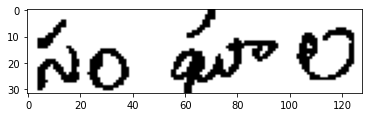

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(imtest[:,:,3234],cmap='gray')
f = imtest[:,:,3234]
f = np.reshape(f,(1,32,128,1))
output = model.predict(f)
print(decode(output))

In [ ]:
def preprocess(imag, imgSize, dataAugmentation=0):
    imag = cv2.medianBlur(imag,3)
    J = cv2.resize(imag,(128,32))
    rt3,_ = cv2.threshold(J,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N,_ = np.histogram(J,[i for i in range(0,256)])
    f = np.argmax(N[int(rt3):])
    rt4 = int(rt3+0.7*f)
    _,k = cv2.threshold(J,rt4,255,cv2.THRESH_BINARY) 
    if dataAugmentation==1:
    	stretch = (random.random() - 0.5) # -0.5 .. +0.5
    	wStretched = max(int(k.shape[1] * (1 + stretch)), 1) # random width, but at least 1
    	k = cv2.resize(k, (wStretched, k.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    (wt, ht) = imgSize
    h = imag.shape[0]
    w = imag.shape[1]
    fx = w / wt #4
    fy = h / ht #3
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(k, newSize)#, cv2.INTER_AREA
    n,_ = np.histogram(img,[i for i in range(257)])
    nn = n[1:255]
    for j in range(len(nn)):
        if (np.sum(nn[:j])-np.sum(nn[j:]))/100 >= 0.25*np.sum(nn):
            break
    rt5 = j+1
    _,ii = cv2.threshold(img,rt5,255,cv2.THRESH_BINARY)
    H,W = ii.shape
    l,b = 32 - H, 128 - W
    if l%2 == 1:
        top, bottom = int(l/2) + 1, int(l/2)
    else:
        top, bottom = int(l/2), int(l/2)
    
    if b%2 == 1:
        left, right = int(b/2) + 1, int(b/2)
    else:
        left, right = int(b/2), int(b/2)
    FinalImage = cv2.copyMakeBorder(ii, top, bottom, left, right, cv2.BORDER_CONSTANT,255,255)
    #rotatedImg = cv2.rotate(FinalImage, cv2.ROTATE_90_CLOCKWISE)
    rotatedImg = cv2.transpose(FinalImage)
    (m, s) = cv2.meanStdDev(rotatedImg)
    m = m[0][0]
    s = s[0][0]
    img = rotatedImg - m
    img = img / s if s>0 else img
    return np.reshape(img,(128,32,1))

def crop(image):
    H,W = image.shape
    _,img = cv2.threshold(image,0,255,cv2.THRESH_OTSU+cv2.THRESH_BINARY)#cv2.THRESH_OTSU+
    vertical = np.sum(img,axis=1)
    p, q, r, s = 0, H, 0, W
    if np.amin(vertical) == 0 and np.argmin(vertical) < int(H/2):
        for m in range(np.argmin(vertical),len(vertical)):
            if vertical[m] != 0:
                break
        p = m+np.argmin(vertical)+1
    if np.amin(vertical[p:]) == 0 and np.argmin(vertical[p:]) > int(H/2):
        q = np.argmin(vertical[p:])-1
    horizontal = np.sum(img,axis=0)
    if np.amin(horizontal) == 0 and np.argmin(horizontal) < int(W/2):
        for n in range(np.argmin(horizontal),len(horizontal)):
            if horizontal[n] != 0:
                break
        r = n+np.argmin(horizontal)+1
    if np.amin(horizontal[r:]) == 0 and np.argmin(horizontal[r:]) > int(W/2):
        s = np.argmin(horizontal[r:])-1
    im = img[p:q,r:s]    
    kernel = np.ones((4,4),dtype='uint8')
    Img = cv2.dilate(im,kernel,iterations=1)
    h, w = Img.shape
    for i in range(w):
        array = Img[:,i]
        l = array.shape[0]
        if np.amin(array) == 0 and np.argmin(array) < 3*int(l/100) and i >= int(w/100):
            for ii in range(np.argmin(array)+1,l):
                if array[ii] != array[ii-1]:
                    #arr = array[ii:]
                    break
            if np.amin(array[ii:]) == 0 and np.argmin(array) < l - 3*int(l/100) and i >= int(w/100):
                a = max(i-1,0)
                break
        elif np.amin(array) == 0 and np.argmin(array) > 3*int(l/100) and np.argmin(array) < l-3*int(l/100) and i >= int(w/100):
            a = max(i-1,0)
            break  
    for j in range(w-1,-1,-1):
        jarray = Img[:,j]
        l = jarray.shape[0]
        if np.amin(jarray) == 0 and np.argmin(jarray) < 3*int(l/100) and j <= w-int(w/100):
            for jj in range(np.argmin(jarray)+1,l):
                if jarray[jj] != jarray[jj-1]:
                    #arr = array[jj:]
                    break
            if np.amin(jarray[jj:]) == 0 and np.argmin(jarray) < l - 3*int(l/100) and j <= w-int(w/100):
                b = j+2 if j>0 else w-1
                break
        elif np.amin(jarray) == 0 and np.argmin(jarray) > 3*int(l/100) and np.argmin(jarray) < l-3*int(l/100) and j <= w-int(w/100):
            b=j+2 if j>0 else w-1
            break           
    imag = Img[:,a:b]
    for k in range(h):
        vector = imag[k,:]
        if np.amin(vector) == 0 and k > 7*int(h/100):
            c = max(k-1,0)
            break    
    for kk in range(h-1,-1,-1):
        array = imag[kk,:]
        if np.amin(array) == 0 and kk < h-4*int(h/100):
            d = kk+1 if kk>0 else h-1
            break
            
    I = im[c:d,a:b]
    J = image[p+c:min(p+d,h),r+a:min(r+b,w)]

    return J

def predict(imgPath):
    img2 = cv2.imread(imgPath,0)
    img2 = crop(img2)
    img2= preprocess(img2,(width,height),0)
    img2 = np.reshape(img2,(1,img2.shape[0],img2.shape[1],1))
    model2 = getModel(False)
    model2.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/CheckPoints/model-036-0.319423_Transpose.hdf5')
    out = model2.predict(img2)
    pred = decode(out)
    print('Recognized Word: '+str(pred))

predict('/content/drive/My Drive/Colab Notebooks/CRNN/TeluguSeg/test/12/1/1.jpg')

NameError: ignored

In [ ]:
model.save('Newtrainval_modelFlipped.hdf5')

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
Lines = readlines(infile)

NameError: ignored

In [ ]:
model.save('Newtrainval_modelflip.hdf5')

In [ ]:
from keras.layers.core import Layer
import tensorflow as tf

class SpatialTransformer(Layer):
    """Spatial Transformer Layer
    Implements a spatial transformer layer as described in [1]_.
    Borrowed from [2]_:
    downsample_fator : float
        A value of 1 will keep the orignal size of the image.
        Values larger than 1 will down sample the image. Values below 1 will
        upsample the image.
        example image: height= 100, width = 200
        downsample_factor = 2
        output image will then be 50, 100
    References
    ----------
    .. [1]  Spatial Transformer Networks
            Max Jaderberg, Karen Simonyan, Andrew Zisserman, Koray Kavukcuoglu
            Submitted on 5 Jun 2015
    .. [2]  https://github.com/skaae/transformer_network/blob/master/transformerlayer.py
    .. [3]  https://github.com/EderSantana/seya/blob/keras1/seya/layers/attention.py
    """

    def __init__(self,
                 localization_net,
                 output_size,
                 **kwargs):
        self.locnet = localization_net
        self.output_size = output_size
        super(SpatialTransformer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.locnet.build(input_shape)
        self.trainable_weights = self.locnet.trainable_weights
        # self.constraints = self.locnet.constraints

    def compute_output_shape(self, input_shape):
        output_size = self.output_size
        return (None,
                int(output_size[0]),
                int(output_size[1]),
                int(input_shape[-1]))

    def call(self, X, mask=None):
        affine_transformation = self.locnet.call(X)
        output = self._transform(affine_transformation, X, self.output_size)
        return output

    def _repeat(self, x, num_repeats):
        ones = tf.ones((1, num_repeats), dtype='int32')
        x = tf.reshape(x, shape=(-1,1))
        x = tf.matmul(x, ones)
        return tf.reshape(x, [-1])

    def _interpolate(self, image, x, y, output_size):
        batch_size = tf.shape(image)[0]
        height = tf.shape(image)[1]
        width = tf.shape(image)[2]
        num_channels = tf.shape(image)[3]

        x = tf.cast(x , dtype='float32')
        y = tf.cast(y , dtype='float32')

        height_float = tf.cast(height, dtype='float32')
        width_float = tf.cast(width, dtype='float32')

        output_height = output_size[0]
        output_width  = output_size[1]

        x = .5*(x + 1.0)*width_float
        y = .5*(y + 1.0)*height_float

        x0 = tf.cast(tf.floor(x), 'int32')
        x1 = x0 + 1
        y0 = tf.cast(tf.floor(y), 'int32')
        y1 = y0 + 1

        max_y = tf.cast(height - 1, dtype='int32')
        max_x = tf.cast(width - 1,  dtype='int32')
        zero = tf.zeros([], dtype='int32')

        x0 = tf.clip_by_value(x0, zero, max_x)
        x1 = tf.clip_by_value(x1, zero, max_x)
        y0 = tf.clip_by_value(y0, zero, max_y)
        y1 = tf.clip_by_value(y1, zero, max_y)

        flat_image_dimensions = width*height
        pixels_batch = tf.range(batch_size)*flat_image_dimensions
        flat_output_dimensions = output_height*output_width
        base = self._repeat(pixels_batch, flat_output_dimensions)
        base_y0 = base + y0*width
        base_y1 = base + y1*width
        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = tf.reshape(image, shape=(-1, num_channels))
        flat_image = tf.cast(flat_image, dtype='float32')
        pixel_values_a = tf.gather(flat_image, indices_a)
        pixel_values_b = tf.gather(flat_image, indices_b)
        pixel_values_c = tf.gather(flat_image, indices_c)
        pixel_values_d = tf.gather(flat_image, indices_d)

        x0 = tf.cast(x0, 'float32')
        x1 = tf.cast(x1, 'float32')
        y0 = tf.cast(y0, 'float32')
        y1 = tf.cast(y1, 'float32')

        area_a = tf.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = tf.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = tf.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = tf.expand_dims(((x - x0) * (y - y0)), 1)
        output = tf.add_n([area_a*pixel_values_a,
                           area_b*pixel_values_b,
                           area_c*pixel_values_c,
                           area_d*pixel_values_d])
        return output

    def _meshgrid(self, height, width):
        x_linspace = tf.linspace(-1., 1., width)
        y_linspace = tf.linspace(-1., 1., height)
        x_coordinates, y_coordinates = tf.meshgrid(x_linspace, y_linspace)
        x_coordinates = tf.reshape(x_coordinates, shape=(1, -1))
        y_coordinates = tf.reshape(y_coordinates, shape=(1, -1))
        ones = tf.ones_like(x_coordinates)
        indices_grid = tf.concat([x_coordinates, y_coordinates, ones], 0)
        return indices_grid

    def _transform(self, affine_transformation, input_shape, output_size):
        batch_size = tf.shape(input_shape)[0]
        height = tf.shape(input_shape)[1]
        width = tf.shape(input_shape)[2]
        num_channels = tf.shape(input_shape)[3]

        affine_transformation = tf.reshape(affine_transformation, shape=(batch_size,2,3))

        affine_transformation = tf.reshape(affine_transformation, (-1, 2, 3))
        affine_transformation = tf.cast(affine_transformation, 'float32')

        width = tf.cast(width, dtype='float32')
        height = tf.cast(height, dtype='float32')
        output_height = output_size[0]
        output_width = output_size[1]
        indices_grid = self._meshgrid(output_height, output_width)
        indices_grid = tf.expand_dims(indices_grid, 0)
        indices_grid = tf.reshape(indices_grid, [-1]) # flatten?
        indices_grid = tf.tile(indices_grid, tf.stack([batch_size]))
        indices_grid = tf.reshape(indices_grid, tf.stack([batch_size, 3, -1]))

        # transformed_grid = tf.batch_matmul(affine_transformation, indices_grid)
        transformed_grid = tf.matmul(affine_transformation, indices_grid)
        x_s = tf.slice(transformed_grid, [0, 0, 0], [-1, 1, -1])
        y_s = tf.slice(transformed_grid, [0, 1, 0], [-1, 1, -1])
        x_s_flatten = tf.reshape(x_s, [-1])
        y_s_flatten = tf.reshape(y_s, [-1])

        transformed_image = self._interpolate(input_shape,
                                              x_s_flatten,
                                              y_s_flatten,
                                              output_size)

        transformed_image = tf.reshape(transformed_image, shape=(batch_size,
                                                                 output_height,
                                                                 output_width,
                                                                 num_channels))
        return transformed_image

In [ ]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.5MB 47kB/s 
     |████████████████████████████████| 3.2MB 48.4MB/s 
     |████████████████████████████████| 368kB 52.2MB/s 
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorflow 2.2.0
    Uninstalling tensorflow-2.2.0:
      Successfully uninstalled tensorflow-2.2.0


In [ ]:
import tensorflow as tf
import keras as k
print(tf.__version__)

1.13.1


In [ ]:
import os
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Flatten, LeakyReLU
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle
#from STN.spatial_transformer import SpatialTransformer
#from VizCallbackTrial import VizCallback

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
batchSize = 64
valBatchSize = 20
width = 128
height = 32
valSplit = 0.02
trainSamplesPerEpoch = 25000
valSamplesPerEpoch = 1000
noEpochs = 50
wordFile = 'Newtrainnval.txt'
unicodes = list(np.load('unicodes.npy',allow_pickle=True))
"""
def binarise(im):
    for i in range(im.shape[2]):
        k = im[:,:,i]
        p = np.max(k)
        q = np.min(k)
        k[k==p] = 1
        k[k==q] = 0
        im[:,:,i] = k
    return im
"""
"""
with open('Newaugmented_data.pickle','rb') as f:
  im = pickle.load(f)
"""

#im = binarise(imw)

dict_trainnval = {}
infile = open('/content/drive/My Drive/Colab Notebooks/CRNN/Newtrainnval.txt','r',encoding='utf-8')
integer = 0
for line in infile:
  integer += 1
  lineSplit = line.strip().split(' ')
  dict_trainnval[lineSplit[0]] = integer

class VizCallback(keras.callbacks.Callback):

    def __init__(self, test_func, nextVal, num_display_words=1):
        self.test_func = test_func
        self.text_img_gen = nextVal
        self.num_display_words = num_display_words
        
    def on_epoch_end(self, epoch, logs={}):
        wordBatch = next(self.text_img_gen)[0]
        imgs = wordBatch['inputX']
        trueText = np.uint8(wordBatch['label'])
        out = self.test_func([imgs])[0]
        predText = decode(out)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):    
            true = labelsToText(list(trueText[i]))
            wordOK += 1 if predText[i]==true else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],true)
            charDist += dist
            charTot += len(true)
            print(true,predText[i])
        charDist = charDist/charTot
        wordOK = wordOK/wordTot
        print('Character Distance(CER):'+str(charDist*100))
        print('Word Accuracy:'+str(wordOK*100))

def plotHistory(history, key = 'loss'):
    plt.figure()
    plt.plot(history.epoch, history.history['val_'+key],'--', label=' Val')
    plt.plot(history.epoch, history.history[key],label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])

def preprocess(imag, imgSize, dataAugmentation=0):
    imag = cv2.medianBlur(imag,3)
    J = cv2.resize(imag,(128,32))
    rt3,_ = cv2.threshold(J,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N,_ = np.histogram(J,[i for i in range(0,256)])
    f = np.argmax(N[int(rt3):])
    rt4 = int(rt3+0.7*f)
    _,k = cv2.threshold(J,rt4,255,cv2.THRESH_BINARY) 
    if dataAugmentation==1:
    	stretch = (random.random() - 0.5) # -0.5 .. +0.5
    	wStretched = max(int(k.shape[1] * (1 + stretch)), 1) # random width, but at least 1
    	k = cv2.resize(k, (wStretched, k.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    (wt, ht) = imgSize
    h = imag.shape[0]
    w = imag.shape[1]
    fx = w / wt #4
    fy = h / ht #3
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(k, newSize)     #cv2.INTER_AREA
    n,_ = np.histogram(img,[i for i in range(257)])
    nn = n[1:255]
    for j in range(len(nn)):
        if (np.sum(nn[:j])-np.sum(nn[j:]))/100 >= 0.25*np.sum(nn):
            break
    rt5 = j+1
    _,ii = cv2.threshold(img,rt5,255,cv2.THRESH_BINARY)
    H,W = ii.shape
    l,b = 32 - H, 128 - W
    if l%2 == 1:
        top, bottom = int(l/2) + 1, int(l/2)
    else:
        top, bottom = int(l/2), int(l/2)
    
    if b%2 == 1:
        left, right = int(b/2) + 1, int(b/2)
    else:
        left, right = int(b/2), int(b/2)
    FinalImage = cv2.copyMakeBorder(ii, top, bottom, left, right, cv2.BORDER_CONSTANT,255,255)
    rotatedImg = cv2.rotate(FinalImage, cv2.ROTATE_90_CLOCKWISE)
    #rotatedImg = cv2.transpose(FinalImage)
    (m, s) = cv2.meanStdDev(rotatedImg)
    m = m[0][0]
    s = s[0][0]
    img = rotatedImg - m
    img = img / s if s>0 else img
    img = np.reshape(img,(128,32,1)).T[:,::-1,:]
    return np.reshape(img,(32,128,1))

def textToLabels(text):
    ret = []
    for c in text:
        ret.append(unicodes.index(c))
    return ret

def labelsToText(labels):
    ret = []
    for c in labels:
        if c == len(unicodes):
            ret.append("")
        else:
            ret.append(unicodes[c])
    return "".join(ret)
        

class DataGenerator(keras.callbacks.Callback):
    def __init__(self,batchSize,valBatchSize,width,height,valSplit,downsampleFactor = 4 , maxStringLen = 32):
        self.batchSize = batchSize
        self.imgW = width
        self.imgH = height
        self.downSampleFactor = downsampleFactor
        self.valSplit = valSplit
        self.blankLabel = len(unicodes)
        self.wordFile = wordFile
        self.maxStringLen = maxStringLen
        self.trainSet = None
        self.valSet = None
        self.dataset = [] 
        self.trainIndex = 0
        self.valBatchSize = valBatchSize
        self.valIndex = 0
        self.getData()
        
    def getData(self):
        f = open(self.wordFile,'r',encoding='utf-8')
        for line in f:
            if not line or line[0] =='#':
                continue
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 2
            fileName = lineSplit[0] # '/content/drive/My Drive/Colab Notebooks/CRNN/' +
            text = self.truncateLabel(' '.join(lineSplit[1:]))
            
            for ch in text:
                if ch not in unicodes:
                    print(ch,('0'+hex(ord(ch))[2:]))
                    
            #text = text.replace('\n','')              #Removing LF newlines
            self.dataset.append((text,fileName))
        self.splitData()
        f.close()
            
    def splitData(self):
        random.shuffle(self.dataset)
        self.valSet = self.dataset[:int(self.valSplit*len(self.dataset))]
        random.shuffle(self.valSet)
        self.trainSet = self.dataset[int(self.valSplit*len(self.dataset)):]
        random.shuffle(self.trainSet)
        self.trainIndex = 0
        self.valIndex = 0
    
    def truncateLabel(self,text):
        cost = 0
        for i in range(len(text)):
            if i!=0 and text[i]==text[i-1]:
                cost+=2
            else:
                cost+=1
            if cost>self.maxStringLen:
                return text[:i]
        return text
    
    def getBatch(self,index,size,train):
        if train:
            batch = self.trainSet[index:index+size]
        else:
            batch = self.valSet[index:index+size]
        imgs = []
        labels = np.ones([size, self.maxStringLen])*(len(unicodes))
        inputLength = np.zeros([size, 1])
        labelLength = np.zeros([size, 1])
        for i in range(size):
            #img = cv2.imread(batch[i][1],0)
            kk = dict_trainnval[batch[i][1]]
            imgs.append(np.reshape(im[:,:,kk-1],(32,128,1)))
            labels[i, 0:len(batch[i][0])] = textToLabels(batch[i][0])
            labelLength[i] = len(batch[i][0])
            inputLength[i] = self.imgW // self.downSampleFactor - 2
        imgs = np.asarray(imgs)
        inputs = {
                'inputX': imgs,
                'label': labels,
                'inputLen':inputLength,
                'labelLen':labelLength,
                    }
        outputs = {'ctc':np.zeros([size])}
        return (inputs,outputs)
            
    def nextTrain(self):
        while True:
            if self.trainIndex + self.batchSize >= len(self.trainSet):
                self.trainIndex = self.trainIndex % self.batchSize
                random.shuffle(self.trainSet)   
            ret = self.getBatch(self.trainIndex,self.batchSize,True)
            self.trainIndex += self.batchSize
            yield ret
            
    def nextVal(self):
        while True:
            if self.valIndex + self.valBatchSize >= len(self.valSet):
                self.valIndex = self.valIndex % self.valBatchSize
                random.shuffle(self.valSet)   
            ret = self.getBatch(self.valIndex,self.valBatchSize,False)
            self.valIndex += self.valBatchSize
            yield ret

def ctcLambdaFunc(args):
    yPred, labels, inputLength, labelLength = args
    yPred = yPred[:,2:,:]
    loss = K.ctc_batch_cost(labels,yPred,inputLength,labelLength)
    return loss
"""
def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inner = Conv2D(64,(3,3),padding = 'same', name = 'ConvName1', kernel_initializer = 'he_normal')(inputs)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = Conv2D(128,(3,3),padding = 'same', name = 'ConvName2', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = Conv2D(256,(3,3),padding = 'same', name = 'ConvName3', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(256,(3,3),padding = 'same', name = 'ConvName4', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName5', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName6', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName7', kernel_initializer = 'he_normal')(inner)
    inner = BatchNormalization()(inner)
    inner = Activation('relu')(inner)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred) 
""" 

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            #x = LeakyReLU()(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            #x = LeakyReLU()(x)
            x = Activation(activation)(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      x = Activation(activation)(x)
      #x = LeakyReLU()(x)
    return x
"""
def res3Block(inputs,
              num_filters=16,
              kernel_size=3,
              activation='relu',
              batch_normalization=True,
              conv_first=True):
    x = inputs
    y = res_block(inputs=x,
                  num_filters=num_filters)
    y = res_block(inputs=y,
                  num_filters=num_filters,
                  A=False)
    x = res_block(inputs=x,
                  num_filters=num_filters,
                  BN=False,
                  A=False)
    x = keras.layers.add([x,y])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((2051, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_fla = Flatten()(loc_input)
    loc_fc_1 = Dense(2051, activation='tanh')(loc_fla)
    loc_fc_2 = Dense(6, weights=weights, activation='tanh')(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output
"""
def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    """
    flat = Flatten()(inputs)
    layer1 = Dense(2051,kernel_initializer='he_normal')(flat)
    layer1 = BatchNormalization()(layer1)
    layer1 = Activation('tanh')(layer1)
    h_fc1 = Dense(6,kernel_initializer='he_normal')(layer1)
    h_fc1 = BatchNormalization()(h_fc1)
    h_fc1 = Activation('tanh')(h_fc1)
    """
    #abc = SpatialTransformer(localization_net=loc_net((32,128,1)), output_size=(32,128))(inputs)
    #abc = Reshape(target_shape=(32,128,1))(abc)
    inner = res_block(inputs,64)
    inner = res_block(inner,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    #Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

def decode(yPred):#Best Path or Beam Search
    """
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    return texts
    """
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts
    
def train(loader,transLearn = False):
    model = getModel(True)
    if transLearn:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/withoutDil/model_89.hdf5')
    model.compile(loss={'ctc': lambda yTrue,yPred: yPred},optimizer = Adadelta())
    
    checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CRNN/WDaugmented/augmodel-{epoch:03d}-{val_loss:03f}.hdf5',verbose=1, monitor='val_loss',save_best_only=False, mode='auto')    
    test_func = K.function([model.inputs[0]],[model.outputs[1]])
    viz_cb = VizCallback(test_func, loader.nextVal())      

    h = model.fit_generator(generator=loader.nextTrain(),
                            workers=1,use_multiprocessing=False,
                    steps_per_epoch= trainSamplesPerEpoch // batchSize,
                    epochs=noEpochs,
                    callbacks=[viz_cb,loader, checkpoint],
                    validation_data = loader.nextVal(),
                    validation_steps = valSamplesPerEpoch // valBatchSize
                    )

    if transLearn:
        model.save('/content/drive/My Drive/Colab Notebooks/CRNN/Model/TransModel.h5') #transModel.h5
    else:
        model.save('/content/drive/My Drive/Shared/CRNN/New_Models/latestPaperModel.h5') #synthModel.h5
    
    plotHistory(h)
    return model,h

def plotAccChange(loader,transLearn = False):
    if transLearn:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/Models')
    else:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models')
    accs = np.zeros((noEpochs,1))
    model = getModel(False)
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        jj = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,jj-1],(32,128,1)))
    imgs = np.array(imgs)    
    for j in range(1,noEpochs+1):
        model.load_weights(str(j)+'.hdf5')
        outputs = model.predict(imgs)
        predText = decode(outputs)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):
            #print(predText[i],trueText[i])
            wordOK += 1 if predText[i]==trueText[i] else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],trueText[i])
            charDist += dist
            charTot += len(trueText[i])
        charDist = charDist/charTot
        accs[j-1] = wordOK/wordTot
        if j == noEpochs:
            print('Character Distance(CER):'+str(charDist*100))
            print('Word Accuracy:'+str(accs[-1]*100))
    plt.figure()
    plt.plot(range(1,noEpochs+1), accs,label=' ValidationAcc')
    plt.xlabel('Epochs')
    plt.legend()
    plt.xlim([0,noEpochs+1])
            

def validate(loader,transAcc = False):
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,nn-1],(32,128,1)))
        #imgs.append(preprocess(img,(width,height),0))
    model = getModel(False)
    """
    if transAcc:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5')
    else:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models/paperModel2.h5')
    """
    model.load_weights('WDaugmented/model_27.hdf5')
    imgs = np.array(imgs)
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))
    
    
def predict(imgPath):
    img2 = cv2.imread(imgPath,0)
    img2= preprocess(img2,(128,32),0)
    img2 = np.reshape(img2,(1,img2.shape[0],img2.shape[1],1))
    model2 = getModel(False)
    model2.load_weights('synthModel.h5')
    out = model2.predict(img2)
    pred = decode(out)
    print('Recognized Word: '+str(pred))


#loader = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
#model,h = train(loader,transLearn = True)
validate(loader)

#os.chdir('D:/OCR/Documents/[8]WordsSKCor')
#wordFile = 'realWords.txt'

#valSplit = 1
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
#validate(loader2)

#noEpochs = 20
#trainSamplesPerEpoch = 1900
#valTransSplit = 0.02
#valSamplesPerEpoch = 40
#valBatchSize = 32
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valTransSplit)
#model2,h2 = train(loader2,transLearn = True)
#plotAccChange(loader2,True)

నటించాలంటూ నటించాలంటూ
చేతిలో చేతిలో
పీల్చేవారు పీల్చేవారు
కాయితం కాయితం
డాలర్లకు డాలర్లకు
ఏవైనా ఏవైనా
డిగ్రీకై డిగ్రీకై
మంత్రిత్వలోని మంత్రిత్వలోని
పాల్గొంటారనడంలోనే పాల్గొంటారనడంలోనే
దానర్థం దానర్థం
ఉంఖ్రుల్ ఉఖ్రుల్
టైర్ల టైర్ల
తవ్వడానికి తవ్వడానికి
హరిప్రసాద హరిప్రసాద
భరించలేదని భరించలేదని
ఆరంభించి ఆరంభించి
నాట్య నాట్య
అతత్వాభినివేశం అతత్వాభినివేశం
వ్యామోహములు వ్యామోహములు
ఎదుగుతున్న ఎదుగుతున్న
చుట్టుకుపోతున్న చుట్టుకుపోతున్న
కొమ్ముకాస్తూ కొమ్ముకాస్తూ
పెంచడానికి పెంచడానికి
అనిపిస్తున్నది అనిపిస్తున్నది
లోబడిపోవడంలోనూ లోబడిపోవడంలోనూ
సన్నీ సన్నీ
సత్కరించడం సత్కరించడం
నాగౌర్ నాగౌర్
చెందినవి చెందినవి
అవసరాల అవసరాల
మైక్రోఫోన్ మైక్రోఫోన్
ప్రదేశానికి ప్రదేశానికి
తారుమారయింది తారుమారయింది
సన్నీ సన్నీ
గ్రామపంచాయతీ గ్రామపంచాయతీ
పల్లెటూరే పల్లెటూరే
దెబ్బతీసే దెబ్బతీసే
స్వల్పకాల స్వల్పకాల
జంతువుల జంతువుల
ప్రశ్నిస్తే ప్రశ్నిస్తే
ఆలోచించినా ఆలోచించినా
సత్య సత్య
బుల్స్ బుల్స్
పరిశోధనల పరిశోధనల
రావడంలేదు రావడంలేదు
పల్లెకోన పల్లెకోన
ఎండగట్టాల్సిన ఎండగట్టాల్సిన
సాగుతున్న సాగుతున్న
నాడి నాడి
విస్తీర్ణము

In [ ]:
import os
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Flatten, LeakyReLU
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
dict_trainnval = {}
unicodes = list(np.load('unicodes.npy',allow_pickle=True))
infile = open('Newtest.txt','r',encoding='utf-8')
integer = 0
for line in infile:
    integer += 1
    lineSplit = line.strip().split(' ')
    dict_trainnval[lineSplit[0]] = integer  

def truncateLabel(text):
    cost = 0
    for i in range(len(text)):
        if i!=0 and text[i]==text[i-1]:
            cost+=2
        else:
            cost+=1
        if cost>29:
            return text[:i]
    return text

def getData():
    dataset = []
    f = open('Newtest.txt','r',encoding='utf-8')
    for line in f:
        if not line or line[0] =='#':
            continue
        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 2
        fileName = lineSplit[0] 
        text = truncateLabel(' '.join(lineSplit[1:]))

        for ch in text:
            if ch not in unicodes:
                print(ch,('0'+hex(ord(ch))[2:]))


        dataset.append((text,fileName))
    f.close()
    return dataset
"""
with open('Newtest_data.pickle','rb') as f:
    imtest = pickle.load(f)
f.close()    
"""

def ctcLambdaFunc(args):
    yPred, labels, inputLength, labelLength = args
    yPred = yPred[:,2:,:]
    loss = K.ctc_batch_cost(labels,yPred,inputLength,labelLength)
    return loss

def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    """
    flat = Flatten()(inputs)
    layer1 = Dense(2051,kernel_initializer='he_normal')(flat)
    layer1 = BatchNormalization()(layer1)
    layer1 = Activation('tanh')(layer1)
    h_fc1 = Dense(6,kernel_initializer='he_normal')(layer1)
    h_fc1 = BatchNormalization()(h_fc1)
    h_fc1 = Activation('tanh')(h_fc1)
    """
    #abc = SpatialTransformer(localization_net=loc_net((32,128,1)), output_size=(32,128))(inputs)
    #abc = Reshape(target_shape=(32,128,1))(abc)
    inner = res_block(inputs,64)
    inner = res_block(inner,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    #Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

def decode(yPred):#Best Path or Beam Search
    """
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    return texts
    """
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts

model = getModel(False)
model.load_weights('WDaugmented/model_27.hdf5')

def Test():
    validation = getData()
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(imtest[:,:,nn-1],(32,128,1)))
    imgs = np.array(imgs)
    
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))    
    
Test()

Streaming output truncated to the last 5000 lines.
వింతగా వింతగా
అభ్యంగ అభ్యంగ
చూపిస్తూనే చూపిస్తూనే
సుబ్బారావుగారు సుబ్బారావుగారు
గట్టి గట్టి
టార్నిడో టార్నెడో
స్టౌపై స్టౌపై
జెర్కన్ జెర్మన్
నేరాలు నేరాలు
మనవరాలి మనవరాలి
అంటాండేవారు అంటూండేవారు
సుద్రసాత్రకమైన షడ్రసాత్మకమైన
సలహా సలహా
అత్యవసరంగా అత్యవసరంగా
సంపాధకియాలు సంపాదకీయాలు
ఆకాశాన్నిన ఆకాశాన్ని
అంతుబట్టనిదే అంతుబట్టనిదే
విత్తన విత్తన
రి్మాట్ రిక్రూట్
గెడువులోగా గడువులోగా
టెక్నాల్ టేక్మాల్
వాళ్లు వాళ్లు
అవసరమ్యే అవసరమ్యే
మాధ్యయంతో మాధ్యమంతో
దోహదపడ్డాయి దొహదపడ్డాయి
మమతా మమతా
హెచ్చరికల హెచ్చరికల
కప్పు కప్పు
భాషల్లోనూ భాషల్లోనూ
గాయంత్రి గాయత్రి
సఖా సభా
వస్త్రాపహరణ వస్త్రాపహరణ
విక్రమార్కుదిలా విక్రమార్కుడిలా
దినాన్ని దినాన్ని
అత్యాశ అత్యాశ
నిబంధనను నిబంధనను
చెప్పసాగాడు చెప్పసాగాడు
వాళ్లాన్దినా వాళ్లనైనా
బెల్లం బెల్లం
జరుగును జరుగును
ఓడించింది ఓడించింది
వ్యాపారులు వ్యాపారులు
ప్రబలిన ప్రబలిన
వంకతాయపై వంకాయపై
తిలియకపోయినా తెలియకపోయినా
కలిగించాయి కలిగించాయి
బాలల్లో బాలల్లో
పరమిత పరమిత
కళ్ళముందే కళ్ళముందే
కులతత్వాన్ని కులతత్వాన్ని
పదాలకు పదా

In [ ]:
import numpy as np
import editdistance as ed
import os
import pickle

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')

unicodes = list(np.load('unicodes.npy',allow_pickle=True))
with open('lexicon.txt','r',encoding='utf-8') as f:
    lexicon = [x.strip() for x in f.readlines()]
    
dict_trainnval = {}
infile = open('Newtest.txt','r',encoding='utf-8')
integer = 0
for line in infile:
    integer += 1
    lineSplit = line.strip().split(' ')
    dict_trainnval[lineSplit[0]] = integer  
infile.close()
    
def decode(yPred):  #Best Path
    """
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    return texts
    """
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word += ""
        else:
          word += unicodes[pred[i]]
      lex = np.zeros(len(lexicon))
      """
      for i in range(len(lex)):
          lex[i] = ed.eval(word,lexicon[i])
      """
      lex = [ed.eval(word,x) for x in lexicon]
      predWord = lexicon[np.argmin(lex)]
      texts.append(predWord)
    return texts

def truncateLabel(text):
    cost = 0
    for i in range(len(text)):
        if i!=0 and text[i]==text[i-1]:
            cost+=2
        else:
            cost+=1
        if cost>29:
            return text[:i]
    return text

def getData():
    dataset = []
    f = open('Newtest.txt','r',encoding='utf-8')
    for line in f:
        if not line or line[0] =='#':
            continue
        lineSplit = line.strip().split(' ')
        assert len(lineSplit) >= 2
        fileName = lineSplit[0] 
        text = truncateLabel(' '.join(lineSplit[1:]))

        for ch in text:
            if ch not in unicodes:
                print(ch,('0'+hex(ord(ch))[2:]))


        dataset.append((text,fileName))
    f.close()
    return dataset

"""
with open('TestPaper.pickle','rb') as f:
    imtest = pickle.load(f)
f.close()    
"""

def Test():
    validation = getData()
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(imtest[:,:,nn-1],(32,128,1)))
    model = getModel(False)
    model.load_weights('WDaugmented/model_32.hdf5')
    imgs = np.array(imgs)
    
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))    
    
Test()

Streaming output truncated to the last 5000 lines.
వింతగా వింతగా
అభ్యంగ అభ్యంగ
చూపిస్తూనే చూపిస్తూనే
సుబ్బారావుగారు సుబ్బారావుగారు
గట్టి గట్టి
టార్నెడో టార్నెడో
స్టౌపై స్టౌపై
జెర్మన్ జెర్మన్
నేరాలు నేరాలు
మనవరాలి మనవరాలి
అంటూండేవారు అంటూండేవారు
షడ్రసాత్మకమైన షడ్రసాత్మకమైన
సలహా సలహా
అత్యవసరంగా అత్యవసరంగా
సంపాదకీయాలు సంపాదకీయాలు
ఆకాశాన్ని ఆకాశాన్ని
అంతుబట్టనిదే అంతుబట్టనిదే
విత్తన విత్తన
నిమాట్ రిక్రూట్
గడువులోగా గడువులోగా
టెక్నాలజీ టేక్మాల్
వాళ్లు వాళ్లు
అవసరమ్యే అవసరమ్యే
మాధ్యమంతో మాధ్యమంతో
దొహదపడ్డాయి దొహదపడ్డాయి
మమతా మమతా
హెచ్చరికల హెచ్చరికల
కప్పు కప్పు
భాషల్లోనూ భాషల్లోనూ
గాయత్రి గాయత్రి
సభా సభా
వస్త్రాపహరణ వస్త్రాపహరణ
విక్రమార్కుడిలా విక్రమార్కుడిలా
దినాన్ని దినాన్ని
అత్యాశ అత్యాశ
నిబంధనను నిబంధనను
చెప్పసాగాడు చెప్పసాగాడు
వాళ్లని వాళ్లనైనా
బెల్లం బెల్లం
జరుగును జరుగును
ఓడించింది ఓడించింది
వ్యాపారులు వ్యాపారులు
ప్రబలిన ప్రబలిన
వంకాయపై వంకాయపై
తెలియకపోయినా తెలియకపోయినా
కలిగించాయి కలిగించాయి
బాలల్లో బాలల్లో
పరమిత పరమిత
కళ్ళముందే కళ్ళముందే
కులతత్వాన్ని కులతత్వాన్ని
పదాలకు పదాలకు
అననుకూ

In [ ]:
!pip install STN

In [ ]:
model.save('ResNetPaper.hdf5')

In [ ]:
def validate(loader,transAcc = False):
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,nn-1],(32,128,1)))
        #imgs.append(preprocess(img,(width,height),0))
    model = getModel(False)
    """
    if transAcc:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5')
    else:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models/paperModel2.h5')
    """
    model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Best_Val_Loss_Models/model-039-0.063399_Paper.hdf5')
    imgs = np.array(imgs)
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))
 
validate(loader)

In [ ]:
import pickle
import os

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')

with open('Newtrainnval_transpose.pickle','rb') as f:
  im = pickle.load(f)

In [ ]:
inputShape = (32,128,1)
kernelVals = [3,3,3,3,3,2]
convFilters = [64,128,256,512,512,512]
strideVals = [(2,2),(2,2),(1,2),(1,2),(1,2)]
rnnUnits = 256
maxStringLen = 128
inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
inner = inputs
for i in range(len(kernelVals)):
  if i==0:
    ConvName = 'conv0'
    MaxPoolName = 'max1'
  elif i==1:
    ConvName = 'conv1'
    MaxPoolName = 'max2'
  elif i==2:
    ConvName = 'conv2'
    MaxPoolName = 'max3'
  elif i==3:
    ConvName = 'conv3'
    MaxPoolName = 'max4'
  elif i==4:
    ConvName = 'conv4'
    MaxPoolName = 'max5'
  inner = Conv2D(convFilters[i],(kernelVals[i],kernelVals[i]),padding = 'same', name = ConvName, kernel_initializer = 'he_normal')(inner)              
  inner = BatchNormalization()(inner)
  inner = Activation('relu')(inner)
  inner = MaxPooling2D(pool_size = strideVals[i],name = MaxPoolName)(inner)
inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

LS1 = average([LSF,LSB])
LS1 = BatchNormalization()(LS1)

LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

LS2 = concatenate([LSF,LSB])
LS2 = BatchNormalization()(LS2)
yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
yPred = Activation('softmax')(yPred)
Model(inputs = inputs,outputs = yPred).summary()

IndexError: ignored

In [ ]:
import os
import tensorflow
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle

inputShape = (32,128,1)
rnnUnits = 256
maxStringLen = 32
inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
inner = Conv2D(64,(3,3),padding = 'same', name = 'ConvName1', kernel_initializer = 'he_normal')(inputs)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
inner = Conv2D(128,(3,3),padding = 'same', name = 'ConvName2', kernel_initializer = 'he_normal')(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
inner = Conv2D(256,(3,3),padding = 'same', name = 'ConvName3', kernel_initializer = 'he_normal')(inner)
inner = Activation('relu')(inner)
inner = Conv2D(256,(3,3),padding = 'same', name = 'ConvName4', kernel_initializer = 'he_normal')(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName5', kernel_initializer = 'he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName6', kernel_initializer = 'he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
inner = Conv2D(512,(3,3),padding = 'same', name = 'ConvName7', kernel_initializer = 'he_normal')(inner)
inner = Activation('relu')(inner)

inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

LS1 = average([LSF,LSB])
LS1 = BatchNormalization()(LS1)

LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

LS2 = concatenate([LSF,LSB])
LS2 = BatchNormalization()(LS2)
yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
yPred = Activation('softmax')(yPred)
Model(inputs = inputs,outputs = yPred).summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputX (InputLayer)          (None, 32, 128, 1)        0         
_________________________________________________________________
ConvName1 (Conv2D)           (None, 32, 128, 64)       640       
_________________________________________________________________
activation_15 (Activation)   (None, 32, 128, 64)       0         
_________________________________________________________________
MaxPoolName1 (MaxPooling2D)  (None, 16, 64, 64)        0         
_________________________________________________________________
ConvName2 (Conv2D)           (None, 16, 64, 128)       73856     
_________________________________________________________________
activation_16 (Activation)   (None, 16, 64, 128)       0         
_________________________________________________________________
MaxPoolName2 (MaxPooling2D)  (None, 8, 32, 128)        0   

In [ ]:
import os
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from stn import spatial_transformer_network as transformer

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      x = Activation('relu')(x)
    return x

n_fc = 6
B, H, W, C = (batchSize, 32, 128, 1)

# identity transform
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32').flatten()

# input placeholder
x = tf.placeholder(tf.float32, [B, H, W, C])

# localization network
W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')
b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
h_fc1 = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1

def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inputs = transformer(inputs, h_fc1)
    inner = res_block(inputs,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)
    

Using TensorFlow backend.


In [ ]:
import os
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from stn import spatial_transformer_network as transformer

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      x = Activation('relu')(x)
    return x

def res3Block(inputs,
              num_filters=16,
              kernel_size=3,
              activation='relu',
              batch_normalization=True,
              conv_first=True):
    x = inputs
    y = res_block(inputs=x,
                  num_filters=num_filters)
    y = res_block(inputs=y,
                  num_filters=num_filters,
                  A=False)
    x = res_block(inputs=x,
                  num_filters=num_filters,
                  BN=False,
                  A=False)
    x = keras.layers.add([x,y])
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

n_fc = 6
B, H, W, C = (batchSize, 32, 128, 1)

# identity transform
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32').flatten()

# input placeholder
x = tf.placeholder(tf.float32, [B, H, W, C])

# localization network
W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')
b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
h_fc1 = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1

def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inputs = transformer(inputs, h_fc1)
    inner = res3Block(inputs,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res3Block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res3Block(inner,256)
    inner = res3Block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res3Block(inner,512)
    inner = res3Block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res3Block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

In [ ]:
import os
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Flatten
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from keras.callbacks import ModelCheckpoint
from stn import spatial_transformer_network as transformer
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle
#from STN.spatial_transformer import SpatialTransformer
#from VizCallbackTrial import VizCallback

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
batchSize = 64
valBatchSize = 20
width = 128
height = 32
valSplit = 0.02
trainSamplesPerEpoch = 25000
valSamplesPerEpoch = 1000
noEpochs = 20
wordFile = 'Newtrainnval.txt'
unicodes = list(np.load('unicodes.npy',allow_pickle=True))

def binarise(im):
    for i in range(im.shape[2]):
        k = im[:,:,i]
        p = np.max(k)
        q = np.min(k)
        k[k==p] = 1
        k[k==q] = 0
        im[:,:,i] = k
    return im

with open('NewtrainnvalPaper.pickle','rb') as f:
  im = pickle.load(f)

#im = binarise(imw)

dict_trainnval = {}
infile = open('/content/drive/My Drive/Colab Notebooks/CRNN/Newtrainnval.txt','r',encoding='utf-8')
integer = 0
for line in infile:
  integer += 1
  lineSplit = line.strip().split(' ')
  dict_trainnval[lineSplit[0]] = integer

class VizCallback(keras.callbacks.Callback):

    def __init__(self, test_func, nextVal, num_display_words=1):
        self.test_func = test_func
        self.text_img_gen = nextVal
        self.num_display_words = num_display_words
        
    def on_epoch_end(self, epoch, logs={}):
        wordBatch = next(self.text_img_gen)[0]
        imgs = wordBatch['inputX']
        trueText = np.uint8(wordBatch['label'])
        out = self.test_func([imgs])[0]
        predText = decode(out)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):    
            true = labelsToText(list(trueText[i]))
            wordOK += 1 if predText[i]==true else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],true)
            charDist += dist
            charTot += len(true)
            print(true,predText[i])
        charDist = charDist/charTot
        wordOK = wordOK/wordTot
        print('Character Distance(CER):'+str(charDist*100))
        print('Word Accuracy:'+str(wordOK*100))

def plotHistory(history, key = 'loss'):
    plt.figure()
    plt.plot(history.epoch, history.history['val_'+key],'--', label=' Val')
    plt.plot(history.epoch, history.history[key],label=' Train')
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    plt.xlim([0,max(history.epoch)])

def preprocess(imag, imgSize, dataAugmentation=0):
    imag = cv2.medianBlur(imag,3)
    J = cv2.resize(imag,(128,32))
    rt3,_ = cv2.threshold(J,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    N,_ = np.histogram(J,[i for i in range(0,256)])
    f = np.argmax(N[int(rt3):])
    rt4 = int(rt3+0.7*f)
    _,k = cv2.threshold(J,rt4,255,cv2.THRESH_BINARY) 
    if dataAugmentation==1:
    	stretch = (random.random() - 0.5) # -0.5 .. +0.5
    	wStretched = max(int(k.shape[1] * (1 + stretch)), 1) # random width, but at least 1
    	k = cv2.resize(k, (wStretched, k.shape[0])) # stretch horizontally by factor 0.5 .. 1.5
    (wt, ht) = imgSize
    h = imag.shape[0]
    w = imag.shape[1]
    fx = w / wt #4
    fy = h / ht #3
    f = max(fx, fy)
    newSize = (max(min(wt, int(w / f)), 1), max(min(ht, int(h / f)), 1)) # scale according to f (result at least 1 and at most wt or ht)
    img = cv2.resize(k, newSize)     #cv2.INTER_AREA
    n,_ = np.histogram(img,[i for i in range(257)])
    nn = n[1:255]
    for j in range(len(nn)):
        if (np.sum(nn[:j])-np.sum(nn[j:]))/100 >= 0.25*np.sum(nn):
            break
    rt5 = j+1
    _,ii = cv2.threshold(img,rt5,255,cv2.THRESH_BINARY)
    H,W = ii.shape
    l,b = 32 - H, 128 - W
    if l%2 == 1:
        top, bottom = int(l/2) + 1, int(l/2)
    else:
        top, bottom = int(l/2), int(l/2)
    
    if b%2 == 1:
        left, right = int(b/2) + 1, int(b/2)
    else:
        left, right = int(b/2), int(b/2)
    FinalImage = cv2.copyMakeBorder(ii, top, bottom, left, right, cv2.BORDER_CONSTANT,255,255)
    rotatedImg = cv2.rotate(FinalImage, cv2.ROTATE_90_CLOCKWISE)
    #rotatedImg = cv2.transpose(FinalImage)
    (m, s) = cv2.meanStdDev(rotatedImg)
    m = m[0][0]
    s = s[0][0]
    img = rotatedImg - m
    img = img / s if s>0 else img
    img = np.reshape(img,(128,32,1)).T[:,::-1,:]
    return np.reshape(img,(32,128,1))

def textToLabels(text):
    ret = []
    for c in text:
        ret.append(unicodes.index(c))
    return ret

def labelsToText(labels):
    ret = []
    for c in labels:
        if c == len(unicodes):
            ret.append("")
        else:
            ret.append(unicodes[c])
    return "".join(ret)
        

class DataGenerator(keras.callbacks.Callback):
    def __init__(self,batchSize,valBatchSize,width,height,valSplit,downsampleFactor = 4 , maxStringLen = 32):
        self.batchSize = batchSize
        self.imgW = width
        self.imgH = height
        self.downSampleFactor = downsampleFactor
        self.valSplit = valSplit
        self.blankLabel = len(unicodes)
        self.wordFile = wordFile
        self.maxStringLen = maxStringLen
        self.trainSet = None
        self.valSet = None
        self.dataset = [] 
        self.trainIndex = 0
        self.valBatchSize = valBatchSize
        self.valIndex = 0
        self.getData()
        
    def getData(self):
        f = open(self.wordFile,'r',encoding='utf-8')
        for line in f:
            if not line or line[0] =='#':
                continue
            lineSplit = line.strip().split(' ')
            assert len(lineSplit) >= 2
            fileName = lineSplit[0] # '/content/drive/My Drive/Colab Notebooks/CRNN/' +
            text = self.truncateLabel(' '.join(lineSplit[1:]))
            
            for ch in text:
                if ch not in unicodes:
                    print(ch,('0'+hex(ord(ch))[2:]))
                    
            #text = text.replace('\n','')              #Removing LF newlines
            self.dataset.append((text,fileName))
        self.splitData()
        f.close()
            
    def splitData(self):
        random.shuffle(self.dataset)
        self.valSet = self.dataset[:int(self.valSplit*len(self.dataset))]
        random.shuffle(self.valSet)
        self.trainSet = self.dataset[int(self.valSplit*len(self.dataset)):]
        random.shuffle(self.trainSet)
        self.trainIndex = 0
        self.valIndex = 0
    
    def truncateLabel(self,text):
        cost = 0
        for i in range(len(text)):
            if i!=0 and text[i]==text[i-1]:
                cost+=2
            else:
                cost+=1
            if cost>self.maxStringLen:
                return text[:i]
        return text
    
    def getBatch(self,index,size,train):
        if train:
            batch = self.trainSet[index:index+size]
        else:
            batch = self.valSet[index:index+size]
        imgs = []
        labels = np.ones([size, self.maxStringLen])*(len(unicodes))
        inputLength = np.zeros([size, 1])
        labelLength = np.zeros([size, 1])
        for i in range(size):
            #img = cv2.imread(batch[i][1],0)
            kk = dict_trainnval[batch[i][1]]
            imgs.append(np.reshape(im[:,:,kk-1],(32,128,1)))
            labels[i, 0:len(batch[i][0])] = textToLabels(batch[i][0])
            labelLength[i] = len(batch[i][0])
            inputLength[i] = self.imgW // self.downSampleFactor - 2
        imgs = np.asarray(imgs)
        inputs = {
                'inputX': imgs,
                'label': labels,
                'inputLen':inputLength,
                'labelLen':labelLength,
                    }
        outputs = {'ctc':np.zeros([size])}
        return (inputs,outputs)
            
    def nextTrain(self):
        while True:
            if self.trainIndex + self.batchSize >= len(self.trainSet):
                self.trainIndex = self.trainIndex % self.batchSize
                random.shuffle(self.trainSet)   
            ret = self.getBatch(self.trainIndex,self.batchSize,True)
            self.trainIndex += self.batchSize
            yield ret
            
    def nextVal(self):
        while True:
            if self.valIndex + self.valBatchSize >= len(self.valSet):
                self.valIndex = self.valIndex % self.valBatchSize
                random.shuffle(self.valSet)   
            ret = self.getBatch(self.valIndex,self.valBatchSize,False)
            self.valIndex += self.valBatchSize
            yield ret

def ctcLambdaFunc(args):
    yPred, labels, inputLength, labelLength = args
    yPred = yPred[:,2:,:]
    loss = K.ctc_batch_cost(labels,yPred,inputLength,labelLength)
    return loss

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            #x = Activation(activation)(x)
            x = LeakyReLU()(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            #x = Activation(activation)(x)
            x = LeakyReLU()(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      #x = Activation('relu')(x)
      x = LeakyReLU()(x)
    return x
"""
# identity transform
initial = np.array([[1., 0, 0], [0, 1., 0]])
initial = initial.astype('float32').flatten()
(H, W, C) = (32, 128, 1)
n_fc = 6
B = batchSize
# localization network
W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')
b_fc1 = tf.Variable(initial_value=initial, name='b_fc1')
h_fc = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1
"""
def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((2051, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_fla = Flatten()(loc_input)
    loc_fc_1 = Dense(2051, activation='tanh')(loc_fla)
    loc_fc_2 = Dense(6, weights=weights, activation='tanh')(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output

def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    """
    flat = Flatten()(inputs)
    layer1 = Dense(2051,kernel_initializer='he_normal')(flat)
    layer1 = BatchNormalization()(layer1)
    layer1 = Activation('tanh')(layer1)
    h_fc1 = Dense(6,kernel_initializer='he_normal')(layer1)
    h_fc1 = BatchNormalization()(h_fc1)
    h_fc = Activation('tanh')(h_fc1)
    """
    call = transformer(inputs, loc_net((32,128,1)), (32,128))
    call = Reshape(target_shape=(32,128,1))(call)
    inner = res_block(call,64)
    inner = res_block(inner,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    #Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

def decode(yPred):#Best Path or Beam Search
    """
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    return texts
    """
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts
    
def train(loader,transLearn = False):
    model = getModel(True)
    if transLearn:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Augmented11/model_30.hdf5')
    model.compile(loss={'ctc': lambda yTrue,yPred: yPred},optimizer = Adadelta())
    
    checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/CRNN/STN/modelSTN-{epoch:03d}-{val_loss:03f}_Paper.hdf5',verbose=1, monitor='val_loss',save_best_only=False, mode='auto')    
    test_func = K.function([model.inputs[0]],[model.outputs[1]])
    viz_cb = VizCallback(test_func, loader.nextVal())      

    h = model.fit_generator(generator=loader.nextTrain(),
                            workers=1,use_multiprocessing=False,
                    steps_per_epoch= trainSamplesPerEpoch // batchSize,
                    epochs=noEpochs,
                    callbacks=[viz_cb,loader, checkpoint],
                    validation_data = loader.nextVal(),
                    validation_steps = valSamplesPerEpoch // valBatchSize
                    )

    if transLearn:
        model.save('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5') #transModel.h5
    else:
        model.save('/content/drive/My Drive/Shared/CRNN/New_Models/paperModelstn.h5') #synthModel.h5
    
    plotHistory(h)
    return model,h

def plotAccChange(loader,transLearn = False):
    if transLearn:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/Models')
    else:
        os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models')
    accs = np.zeros((noEpochs,1))
    model = getModel(False)
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        jj = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,jj-1],(32,128,1)))
    imgs = np.array(imgs)    
    for j in range(1,noEpochs+1):
        model.load_weights(str(j)+'.hdf5')
        outputs = model.predict(imgs)
        predText = decode(outputs)
        wordOK = 0
        wordTot = 0
        charDist = 0
        charTot = 0
        for i in range(len(predText)):
            #print(predText[i],trueText[i])
            wordOK += 1 if predText[i]==trueText[i] else 0
            wordTot += 1
            dist = editdistance.eval(predText[i],trueText[i])
            charDist += dist
            charTot += len(trueText[i])
        charDist = charDist/charTot
        accs[j-1] = wordOK/wordTot
        if j == noEpochs:
            print('Character Distance(CER):'+str(charDist*100))
            print('Word Accuracy:'+str(accs[-1]*100))
    plt.figure()
    plt.plot(range(1,noEpochs+1), accs,label=' ValidationAcc')
    plt.xlabel('Epochs')
    plt.legend()
    plt.xlim([0,noEpochs+1])
            

def validate(loader,transAcc = False):
    validation = loader.valSet
    imgs = []
    trueText = []
    for (i,path) in validation:
        trueText.append(i)
        #img = cv2.imread(path,0)
        nn = dict_trainnval[path]
        imgs.append(np.reshape(im[:,:,nn-1],(32,128,1)))
        #imgs.append(preprocess(img,(width,height),0))
    model = getModel(False)
    """
    if transAcc:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/Models/transModel.h5')
    else:
        model.load_weights('/content/drive/My Drive/Colab Notebooks/CRNN/New_Models/paperModel2.h5')
    """
    model.load_weights('Augmented11/model_35.hdf5')
    imgs = np.array(imgs)
    outputs = model.predict(imgs)
    predText = decode(outputs)
    
    wordOK = 0
    wordTot = 0
    charDist = 0
    charTot = 0
    for i in range(len(predText)):
        print(predText[i],trueText[i])
        wordOK += 1 if predText[i]==trueText[i] else 0
        wordTot += 1
        dist = editdistance.eval(predText[i],trueText[i])
        charDist += dist
        charTot += len(trueText[i])
        
    charDist = charDist/charTot
    wordOK = wordOK/wordTot
    print('Character Distance(CER):'+str(charDist*100))
    print('Word Accuracy:'+str(wordOK*100))
    
    
def predict(imgPath):
    img2 = cv2.imread(imgPath,0)
    img2= preprocess(img2,(128,32),0)
    img2 = np.reshape(img2,(1,img2.shape[0],img2.shape[1],1))
    model2 = getModel(False)
    model2.load_weights('synthModel.h5')
    out = model2.predict(img2)
    pred = decode(out)
    print('Recognized Word: '+str(pred))


loader = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
model,h = train(loader,transLearn = False)
#validate(loader)

#os.chdir('D:/OCR/Documents/[8]WordsSKCor')
#wordFile = 'realWords.txt'

#valSplit = 1
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valSplit)
#validate(loader2)

#noEpochs = 20
#trainSamplesPerEpoch = 1900
#valTransSplit = 0.02
#valSamplesPerEpoch = 40
#valBatchSize = 32
#loader2 = DataGenerator(batchSize,valBatchSize,width,height,valTransSplit)
#model2,h2 = train(loader2,transLearn = True)
#plotAccChange(loader2,True)

Using TensorFlow backend.


ValueError: ignored

In [ ]:
pip install stn

In [1]:
import os
import tensorflow as tf
import numpy as np
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Flatten, LeakyReLU
from keras.layers import Reshape, Lambda, BatchNormalization
from keras.layers import Input, Conv2D, MaxPool2D,BatchNormalization, Bidirectional, LSTM, Dense, Lambda
from keras.layers.merge import average, concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.optimizers import Adadelta
import keras.callbacks
from keras.callbacks import ModelCheckpoint
import random
import cv2
import editdistance
import itertools
import matplotlib.pyplot as plt
import pickle

os.chdir('/content/drive/My Drive/Colab Notebooks/CRNN')
"""
def ctcLambdaFunc(args):
    yPred, labels, inputLength, labelLength = args
    yPred = yPred[:,2:,:]
    loss = K.ctc_batch_cost(labels,yPred,inputLength,labelLength)
    return loss

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal')

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
            #x = LeakyReLU()(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            #x = LeakyReLU()(x)
            x = Activation(activation)(x)
        x = conv(x)
    return x

def res_block(inputs,
              num_filters=16,
              kernel_size=3,
              strides=1,
              activation='relu',
              batch_normalization=True,
              conv_first=True,
              BN=True,
              A=True):
    x = inputs
    y = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides)
    y = resnet_layer(inputs=y,
                    num_filters=num_filters,
                    activation=None)
    x = resnet_layer(inputs=x,
                    num_filters=num_filters,
                    strides=strides,
                    activation=None,
                    batch_normalization=False)
    x = keras.layers.add([x, y])
    if BN:
      x = BatchNormalization()(x)
    if A:
      x = Activation(activation)(x)
      #x = LeakyReLU()(x)
    return x

def getModel(training):
    inputShape = (32,128,1)
    rnnUnits = 256
    maxStringLen = 32
    inputs = Input(name = 'inputX', shape = inputShape, dtype = 'float32')
    inner = res_block(inputs,64)
    inner = res_block(inner,64)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName1')(inner)
    inner = res_block(inner,128)
    inner = res_block(inner,128)
    inner = MaxPooling2D(pool_size = (2,2),name = 'MaxPoolName2')(inner)
    inner = res_block(inner,256)
    inner = res_block(inner,256)
    inner = MaxPooling2D(pool_size = (1,2),strides = (2,2), name = 'MaxPoolName4')(inner)
    inner = res_block(inner,512)
    inner = res_block(inner,512)
    inner = MaxPooling2D(pool_size = (1,2), strides = (2,2), name = 'MaxPoolName6')(inner)
    inner = res_block(inner,512)

    inner = Reshape(target_shape = (maxStringLen,rnnUnits), name = 'reshape')(inner)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM1F')(inner)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM1B')(inner)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS1 = average([LSF,LSB])
    LS1 = BatchNormalization()(LS1)

    LSF = LSTM(rnnUnits,return_sequences=True,kernel_initializer='he_normal',name='LSTM2F')(LS1)
    LSB = LSTM(rnnUnits,return_sequences=True, go_backwards = True, kernel_initializer='he_normal',name='LSTM2B')(LS1)
    LSB = Lambda(lambda inputTensor: K.reverse(inputTensor,axes=1))(LSB)

    LS2 = concatenate([LSF,LSB])
    LS2 = BatchNormalization()(LS2)
    yPred = Dense(len(unicodes)+1,kernel_initializer='he_normal',name='dense2')(LS2)
    yPred = Activation('softmax')(yPred)
    #Model(inputs = inputs,outputs = yPred).summary()

    labels = Input(name='label', shape=[32], dtype='float32')
    inputLength = Input(name='inputLen', shape=[1], dtype='int64')     # (None, 1)
    labelLength = Input(name='labelLen', shape=[1], dtype='int64')
    
    lossOut = Lambda(ctcLambdaFunc, output_shape=(1,), name='ctc')([yPred, labels, inputLength, labelLength])
    
    if training:
        return Model(inputs = [inputs, labels, inputLength, labelLength], outputs=[lossOut,yPred])
    return Model(inputs=[inputs], outputs=yPred)

unicodes = list(np.load('unicodes.npy',allow_pickle=True))

def decode(yPred):#Best Path or Beam Search
    texts = []
    for y in yPred:
        label = list(np.argmax(y[2:],1))
        label = [k for k, g in itertools.groupby(label)]
        text = labelsToText(label)
        texts.append(text)
    return texts
    
    texts = []
    for i in range(yPred.shape[0]):
      y = yPred[i,2:,:]
      y = np.reshape(y,(1,30,97))
      pred =  K.get_value(K.ctc_decode(y, input_length=np.ones(y.shape[0])*30, greedy=False, beam_width=3, top_paths=1)[0][0])[0]
      word = ""
      for i in range(len(pred)):
        if pred[i] == len(unicodes):
          word+= ""
        else:
          word += unicodes[pred[i]]
      texts.append(word)
    return texts

model = getModel(False)
model.load_weights('Complete_Trained_Models/ResNetBestNew.hdf5')
"""
from tensorflow.contrib import lite
converter = lite.TFLiteConverter.from_keras_model_file('Complete_Trained_Models/ResNetBestNew.hdf5')
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ResNetBestNew.tflite', 'wb') as f:
  f.write(tflite_model)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.


TypeError: ignored

In [9]:
pip install tensorflow==1.13.1


     |████████████████████████████████| 92.5MB 68kB/s 
     |████████████████████████████████| 368kB 38.0MB/s 
     |████████████████████████████████| 3.2MB 40.2MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
